# Note:

Be sure running **UK(Overall).R** and **ErrorTerm Generation.R** before running this script

Creating data **2 month** before and after the tretment

In [1]:
uk21 <- uk[time(uk) >= "2007-11-10",]
uk21 <- uk21[time(uk21) <= "2008-03-08",]
dateuk21 <- seq(as.Date("2007-11-10"),as.Date("2008-03-08"), by="day")

Loading required package: leaps
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22
Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-17. For overview type 'help("mgcv-package")'.
Loading required package: tseries

Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts
Loading required package: boot
Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.


Generating error components

**Note:** **lperror1** are genereated from **ErrorTerm Generation.R**

In [2]:
set.seed(1431232)
lperror1 <- rnorm(120, 0, lpsd1)

Creating poll data with decimals

In [3]:
uk21$Lab_p <- uk21$Lab/100

Adding error into the imputed data

In [4]:
for (i in 1:nrow(uk21)){
	if (is.na(uk21$poll[i])==TRUE) {
	uk21$Lab_p[i] <- uk21$Lab_p[i] + lperror1[i]
	} else {
		uk21$Lab_p[i] <- uk21$Lab_p[i]
	}
}

Transforming the number to percentage

In [5]:
uk21$Lab <- uk21$Lab_p*100

Creating the daily times series data

In [6]:
uk21r <- zoo(uk21, dateuk21)

Plotting the time-series data

Searching for the index of the date when scandal happend

In [7]:
which(time(uk21r)=="2008-01-09")

[1] 61

Creating values for vline, one for each panel

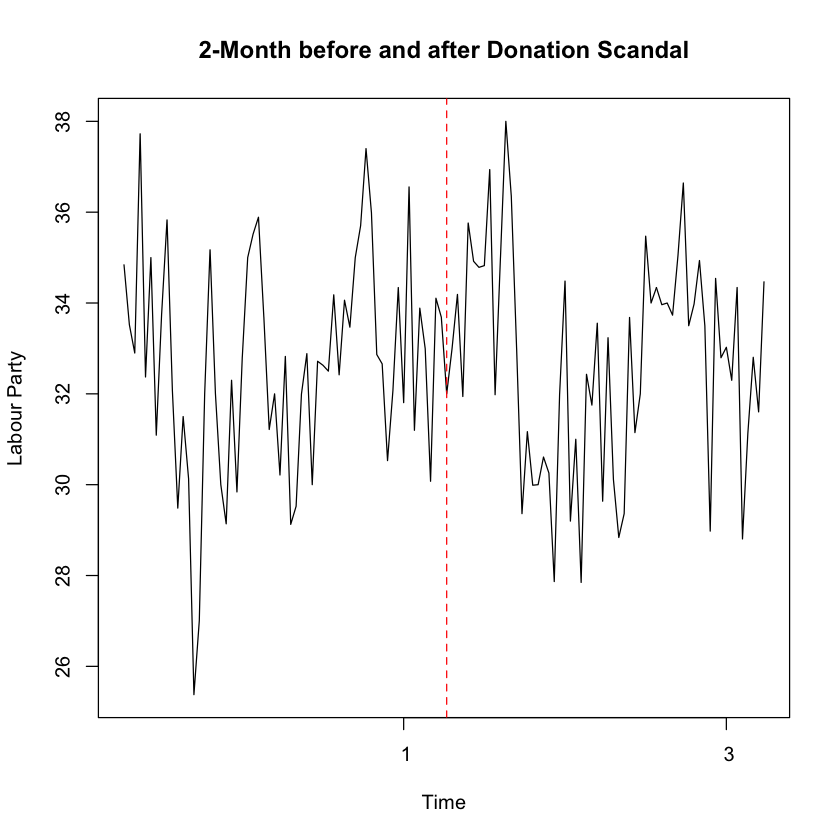

In [8]:
vlines <- c(v=time(uk21r)[61], v=time(uk21r)[61])
v.panel <- function(x, ...){
	lines(x, ...)
	panel.number <- parent.frame()$panel.number
	abline(v = vlines[panel.number], col = "red", lty=2)
}
plot(time(uk21r), uk21r$Lab, main="2-Month before and after Donation Scandal", xlab="Time", type="l",
	 ylab="Labour Party")
abline(v=time(uk21r)[61], lty=2, col="red")

Creating time indicator

In [9]:
nrow(uk21r)

[1] 120

In [10]:
uk21r$t <- seq(1,120,1)

Creating treatment variable

In [11]:
uk21r$scandal1 <- c(rep(0, 60), 1, rep(0, nrow(uk21r)-61))
uk21r$scandal2 <- c(rep(0, 60), rep(1, nrow(uk21r)-60))
uk21r$scandal3 <- c(rep(0, 120))

Testing the model specification for this data

In [12]:
summary(ur.df(uk21r$Lab, type="drift", selectlags="BIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2551 -1.6456  0.1472  1.5770  4.8755 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 16.94044    3.32018   5.102 1.34e-06 ***
z.lag.1     -0.51917    0.10155  -5.113 1.28e-06 ***
z.diff.lag  -0.14567    0.09241  -1.576    0.118    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.194 on 115 degrees of freedom
Multiple R-squared:  0.3171,	Adjusted R-squared:  0.3053 
F-statistic:  26.7 on 2 and 115 DF,  p-value: 2.981e-10


Value of test-statistic is: -5.1127 13.0697 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.46 -2.88 -2.57
phi1  6.52  4.63  3.81


It shows that this time-series is **stationary** under 5% critical value

Testing for the **DGS** of this time-series

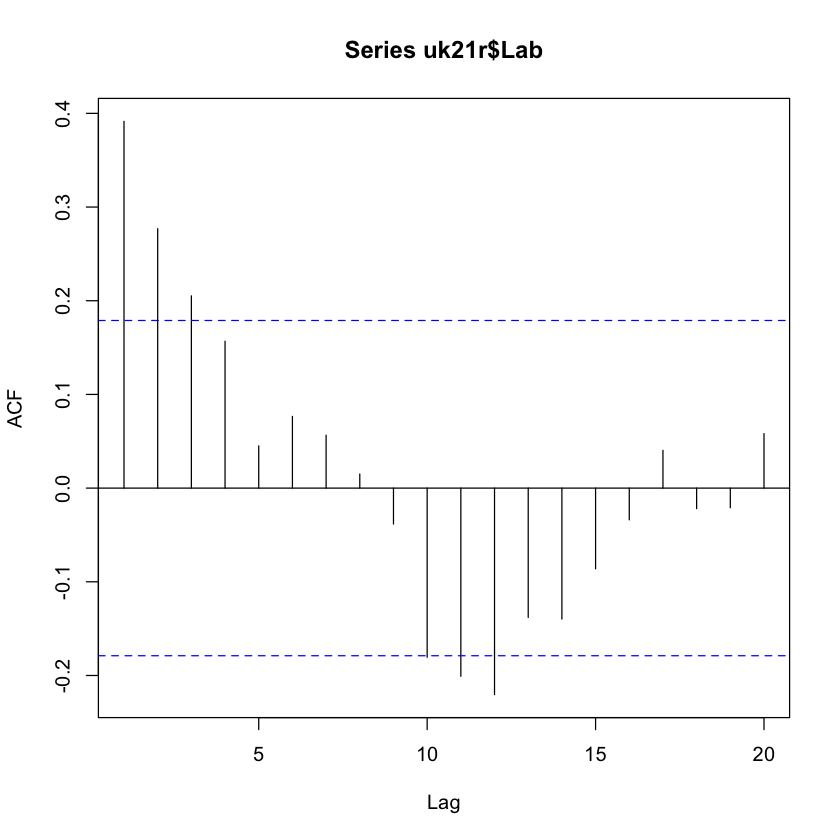

In [13]:
acf(uk21r$Lab)

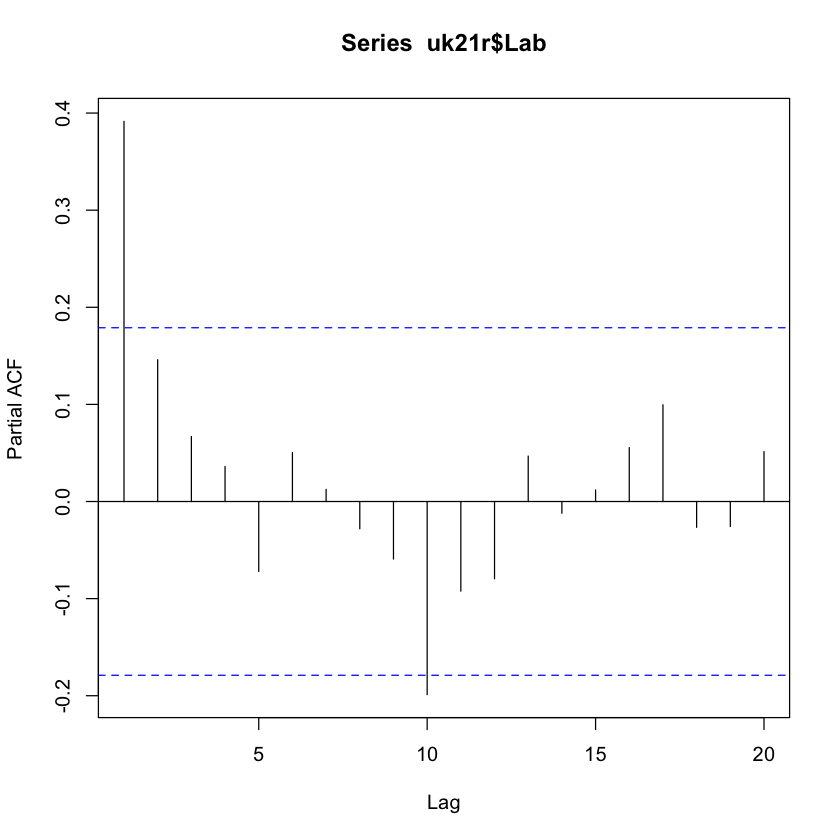

In [14]:
pacf(uk21r$Lab)

In [15]:
uk21r.lab.ar1 <- arimax(uk21r$Lab[1:60], order=c(1,0,0))
uk21r.lab.ar2 <- arimax(uk21r$Lab[1:60], order=c(2,0,0))
uk21r.lab.ar3 <- arimax(uk21r$Lab[1:60], order=c(3,0,0))
uk21r.lab.ar4 <- arimax(uk21r$Lab[1:60], order=c(4,0,0))
uk21r.lab.ar5 <- arimax(uk21r$Lab[1:60], order=c(5,0,0))

BIC(uk21r.lab.ar1, uk21r.lab.ar2, uk21r.lab.ar3, uk21r.lab.ar4, uk21r.lab.ar5)

,df,BIC
uk21r.lab.ar1,3,276.7532
uk21r.lab.ar2,4,280.3459
uk21r.lab.ar3,5,284.4264
uk21r.lab.ar4,6,288.4551
uk21r.lab.ar5,7,292.4309


**BIC** shows **AR(1)** is the best for this data

Estimating the model

In [16]:
uk21r.lab <- arimax(uk21r$Lab, order=c(1,0,0),
					xreg=cbind(uk21r$t, uk21r$scandal2, uk21r$t*uk21r$scandal2)); uk21r.lab


Call:
arimax(x = uk21r$Lab, order = c(1, 0, 0), xreg = cbind(uk21r$t, uk21r$scandal2, 
    uk21r$t * uk21r$scandal2))

Coefficients:
         ar1  intercept  uk21r$t  uk21r$scandal2  uk21r$t * uk21r$scandal2
      0.3880    32.1712   0.0171          0.7074                   -0.0194
s.e.  0.0845     0.9031   0.0255          2.5427                    0.0369

sigma^2 estimated as 4.729:  log likelihood = -263.58,  aic = 537.15

Testing autocorrelation

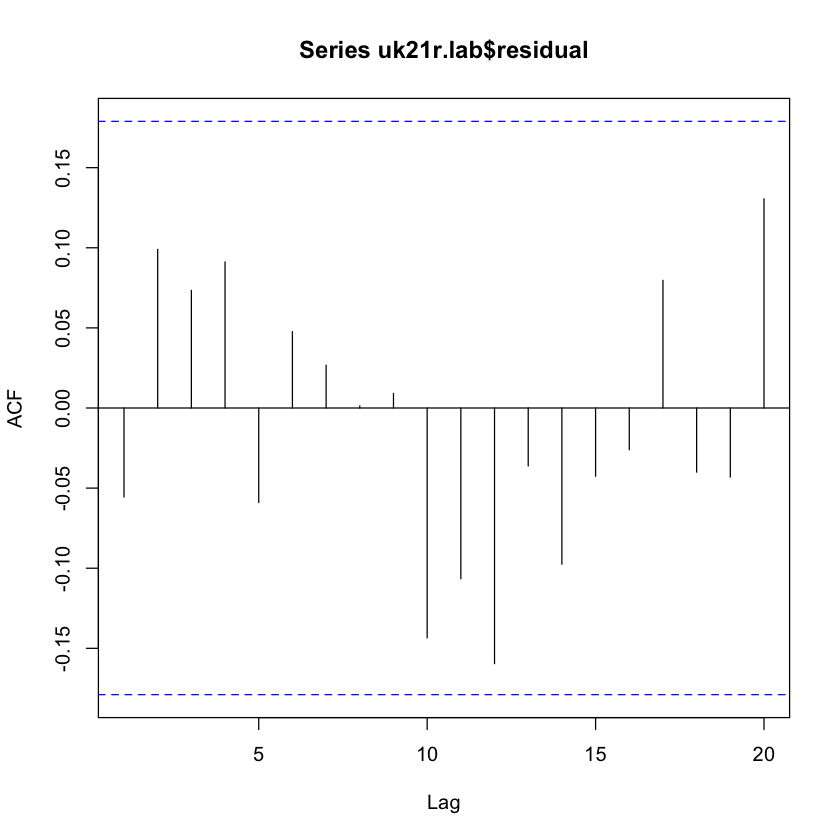

In [17]:
acf(uk21r.lab$residual)

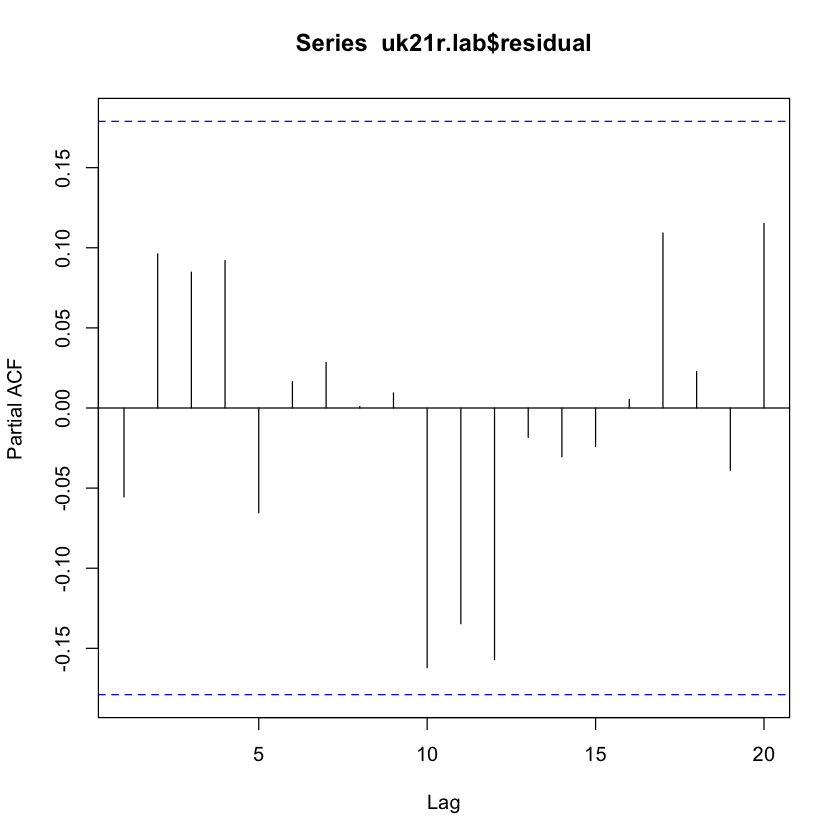

In [18]:
pacf(uk21r.lab$residual)

In [19]:
Box.test(uk21r.lab$residual, lag=20, type="Ljung-Box")


	Box-Ljung test

data:  uk21r.lab$residual
X-squared = 17.62, df = 20, p-value = 0.6124


The results show that there is **no autocorrelation**

In [20]:
uk21r.lab.pred1 <- uk21r.lab$coef[2] + uk21r.lab$coef[3]*uk21r$t + uk21r.lab$coef[4]*uk21r$scandal2 + 
				   uk21r.lab$coef[5]*uk21r$t*uk21r$scandal2

uk21r.lab.pred2 <- uk21r.lab$coef[2] + uk21r.lab$coef[3]*uk21r$t + uk21r.lab$coef[4]*uk21r$scandal3 + 
				   uk21r.lab$coef[5]*uk21r$t*uk21r$scandal3		  

uk21r.lab.diff <- uk21r.lab.pred1[61] - uk21r.lab.pred2[61]

sprintf ("The difference is %s", uk21r.lab.diff)

[1] "The difference is -0.477670526607817"

Parametric **Monte Carlo** Simulation for **95% CIs** (for plotting)

In [21]:
lab1coef <- uk21r.lab$coef
lab1vcov <- vcov(uk21r.lab)
lab1draw <- mvrnorm(5000, lab1coef, lab1vcov)
uk21r$intercept <- rep(1, 120)
lab1xs <- cbind(uk21r$intercept,uk21r$t,uk21r$scandal2,uk21r$t*uk21r$scandal2)
lab1mcci <- lab1xs%*%t(lab1draw[,2:5])
lab1lb <- apply(lab1mcci, 1, function(x) quantile(x, probs=c(.025)))
lab1ub <- apply(lab1mcci, 1, function(x) quantile(x, probs=c(.975)))

Graph for **Local Effect**

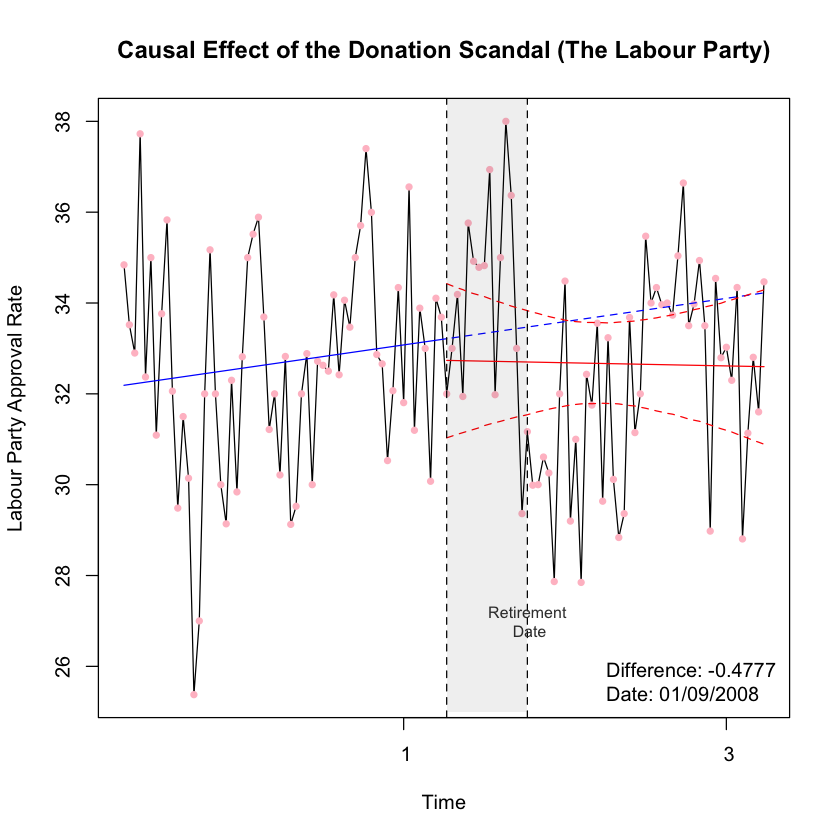

In [22]:
plot(y=uk21r$Lab, x=time(uk21r), type='l', ylab="Labour Party Approval Rate", xlab="Time",
	main="Causal Effect of the Donation Scandal (The Labour Party)")
points(time(uk21r),uk21r$Lab,
       col="pink",
       pch=20)	
lines(y=uk21r.lab.pred2[1:61], x=time(uk21r)[1:61], lty=1, col="blue")
lines(y=uk21r.lab.pred2[62:120], x=time(uk21r)[62:120], lty=2, col="blue")
lines(y=uk21r.lab.pred1[61:length(uk21r.lab.pred1)], x=time(uk21r)[61:length(uk21r.lab.pred1)], 
	  lty=1, col="red")
lines(y=lab1lb[61:120], x=time(uk21r)[61:120], lty=2, col="red")
lines(y=lab1ub[61:120], x=time(uk21r)[61:120], lty=2, col="red")
abline(v=time(uk21r)[61], lty=2)
abline(v=time(uk21r)[76], lty=2)
text(x = time(uk21r)[76], y = 27, paste("Retirement\n", "Date"), col="#3C3C3C", cex=0.8)
# Add a box to show the period between two events
rect(time(uk21r)[61], 25, time(uk21r)[76], 40, border=NA, col="#00000011")
Corner_text <- function(text, location="bottomright"){
	legend(location, legend=text, bty="n", pch=NA)
}
Corner_text(text=c("Difference: -0.4777", "Date: 01/09/2008"))

There is **No Break Point(s)**

**Note:** The break points are detected through the **GAUSS** codes